In [1]:
from __future__ import division
import random
import pprint
import sys
import time
import numpy as np
from optparse import OptionParser
import pickle

from keras import backend as K
from keras.optimizers import Adam, SGD, RMSprop
from keras.layers import Input
from keras.models import Model
from rcnn import config, data_generators
from rcnn import losses as losses
import rcnn.roi_helpers as roi_helpers
from keras.utils import generic_utils
from keras.layers import TimeDistributed, Lambda

import tensorflow as tf
from rcnn.clstm import clstm

sess = tf.Session()
K.set_session(sess)

sys.setrecursionlimit(40000)

parser = OptionParser()

video_path = './videos'
annotation_path = './annotations'
num_rois = 32
num_epochs = 2000
config_filename = 'config.pickle'
output_weight_path = './model_frcnn.hdf5'
input_weight_path = None

from rcnn.video_parser import get_data

C = config.Config()

C.use_horizontal_flips = False
C.use_vertical_flips = False
C.rot_90 = False

C.model_path = output_weight_path
C.num_rois = int(num_rois)

from rcnn import simple_nn as nn
C.network = 'simple_nn'

# check if weight path was passed via command line
if input_weight_path:
    C.base_net_weights = input_weight_path

all_videos, classes_count, class_mapping = get_data(video_path, annotation_path)

if 'bg' not in classes_count:
    classes_count['bg'] = 0
    class_mapping['bg'] = len(class_mapping)

C.class_mapping = class_mapping

inv_map = {v: k for k, v in class_mapping.items()}

print('Training images per class:')
pprint.pprint(classes_count)
print('Num classes (including bg) = {}'.format(len(classes_count)))

config_output_filename = config_filename

with open(config_output_filename, 'wb') as config_f:
    pickle.dump(C,config_f)
    print('Config has been written to {}, and can be loaded when testing to ensure correct results'.format(config_output_filename))

random.shuffle(all_videos)

num_imgs = len(all_videos)

#train_videos = [s for s in all_videos if s['imageset'] == 'trainval']
#val_videos = [s for s in all_videos if s['imageset'] == 'test']
train_videos = all_videos
val_videos = all_videos

print('Num train samples {}'.format(len(train_videos)))
print('Num val samples {}'.format(len(val_videos)))


data_gen_train = data_generators.video_streamer(train_videos, classes_count, C, nn.get_img_output_length, K.image_dim_ordering(), mode='train')
data_gen_val = data_generators.video_streamer(val_videos, classes_count, C, nn.get_img_output_length,K.image_dim_ordering(), mode='val')

input_shape_img = (None, None, None, 3)

num_anchors = len(C.anchor_box_scales) * len(C.anchor_box_ratios)

video_input = tf.placeholder(tf.float32, [None,None,None,None,3])
rpn_target_cls = tf.placeholder(tf.float32, [None,None,None,None,2*num_anchors])
rpn_target_reg = tf.placeholder(tf.float32, [None,None,None,None,2*num_anchors*4])
#roi_input = Input(shape=(None, None, 4))

nb_clstm_filter = 40

def time_broadcast(f, x):
    shape = tf.shape(x)
    num_videos, num_frames, w, h, c = [shape[i] for i in range(5)]

    time_flat = tf.reshape(x, [-1, w,h,c])

    y = f(time_flat)

    shape = tf.shape(y)
    _, w, h, c = [shape[i] for i in range(4)]
    y = tf.reshape(y, [num_videos, num_frames, w, h, c])
    return y


def build_shared(video_input):
    with tf.name_scope('shared_layers'):
        base = nn.nn_base(trainable=True)
        shared_layers = time_broadcast(base, video_input)

        num_channels = 64

        shared_layers = clstm(shared_layers,num_channels,nb_clstm_filter,3)
    return shared_layers

shared = build_shared(video_input)

def build_rpn(x):
    with tf.name_scope('RPN'):
        
        shape = tf.shape(shared)
        num_videos, num_frames, w, h, c = [shape[i] for i in range(5)]
        c = nb_clstm_filter

        time_flat = tf.reshape(x, [-1, w,h,c])

        y_cls, y_reg, _ = nn.rpn(num_anchors)(time_flat)

        shape = tf.shape(y_cls)
        _, w, h, c = [shape[i] for i in range(4)]

        y_cls = tf.reshape(y_cls, [num_videos, num_frames, w, h, c])
        y_reg = tf.reshape(y_reg, [num_videos, num_frames, w, h, c*4])
        return y_cls, y_reg

rpn = build_rpn(shared)
#classifier = nn.classifier(shared_layers, roi_input, C.num_rois, nb_classes=len(classes_count), trainable=True)

#model_rpn = Model(img_input, rpn[:2])
#model_classifier = Model([img_input, roi_input], classifier)

# this is a model that holds both the RPN and the classifier, used to load/save weights for the models
#model_all = Model([img_input, roi_input], rpn[:2] + classifier)


optimizer = tf.train.AdamOptimizer(0.001)

rpn_loss = losses.rpn_loss_regr(num_anchors)(rpn_target_reg, rpn[1]) \
        + losses.rpn_loss_cls(num_anchors)(rpn_target_cls, rpn[0])

rpn_train_op = optimizer.minimize(rpn_loss)

def run_rpn(X, Y):
    sess.run(rpn_train_op, {video_input: X, rpn_target_cls: Y[0], rpn_target_reg: Y[1]}) 

#model_rpn.compile(optimizer=optimizer, loss=[losses.rpn_loss_cls(num_anchors), losses.rpn_loss_regr(num_anchors)])

#model_classifier.compile(optimizer=optimizer_classifier, loss=[losses.class_loss_cls, losses.class_loss_regr(len(classes_count)-1)], metrics={'dense_class_{}'.format(len(classes_count)): 'accuracy'})
#model_all.compile(optimizer='sgd', loss='mae')

epoch_length = 1000
num_epochs = int(num_epochs)
iter_num = 0

losses = np.zeros((epoch_length, 5))
rpn_accuracy_rpn_monitor = []
rpn_accuracy_for_epoch = []
start_time = time.time()

best_loss = np.Inf

class_mapping_inv = {v: k for k, v in class_mapping.items()}
print('Starting training')

vis = True



Using TensorFlow backend.


Parsing annotation files
Training images per class:
{'bbox': 9852, 'bg': 0}
Num classes (including bg) = 2
Config has been written to config.pickle, and can be loaded when testing to ensure correct results
Num train samples 20
Num val samples 20
Starting training


In [3]:
import rcnn

In [4]:
import rcnn.data_augment as data_augment

In [5]:
img_data_aug, x_img = data_augment.augment(all_videos[0][0], C, False)

In [6]:
img_data_aug

{'bboxes': [{'class': 'bbox', 'x1': 198, 'x2': 278, 'y1': 102, 'y2': 184},
  {'class': 'bbox', 'x1': 227, 'x2': 319, 'y1': 225, 'y2': 319}],
 'filepath': './videos/7/0.jpg',
 'height': 320,
 'width': 320}

In [7]:
x_img.shape

(320, 320, 3)

In [8]:
all_videos[0][0]

{'bboxes': [{'class': 'bbox', 'x1': 198, 'x2': 278, 'y1': 102, 'y2': 184},
  {'class': 'bbox', 'x1': 227, 'x2': 319, 'y1': 225, 'y2': 319}],
 'filepath': './videos/7/0.jpg',
 'height': 320,
 'width': 320}

In [2]:
from rcnn.data_generators import get_new_img_size, calc_rpn, get_anchor
import cv2

In [3]:
anc = get_anchor(all_videos[0][0], 2, C, lambda x,y: [x,y], 'tf', mode='val')

In [18]:
C.

300

In [17]:
cls, reg = calc_rpn(C, all_videos[0][0], 320, 320, 320, 320, lambda x,y: [x,y])

(8, 14)
(16, 16)


In [11]:
all_videos[0][0]

{'bboxes': [{'class': 'bbox', 'x1': 198, 'x2': 278, 'y1': 102, 'y2': 184},
  {'class': 'bbox', 'x1': 227, 'x2': 319, 'y1': 225, 'y2': 319}],
 'filepath': './videos/7/0.jpg',
 'height': 320,
 'width': 320}

In [5]:
X.shape

NameError: name 'X' is not defined

In [4]:
anc[0][0].shape, anc[1][0][0].shape

((32, 32, 3), (32, 32, 30))

In [5]:
from matplotlib import pyplot as plt

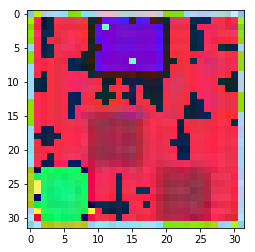

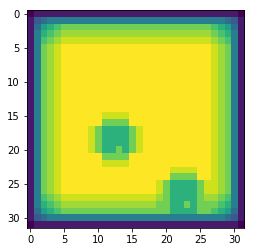

In [7]:
plt.imshow(anc[0][0])
plt.show()
plt.imshow(anc[1][0][0].sum(axis=-1))#[:30, :30])
plt.show()

In [60]:
from __future__ import absolute_import
import numpy as np
import cv2
import random
import copy
from . import data_augment
import threading
import itertools


def union(au, bu, area_intersection):
    area_a = (au[2] - au[0]) * (au[3] - au[1])
    area_b = (bu[2] - bu[0]) * (bu[3] - bu[1])
    area_union = area_a + area_b - area_intersection
    return area_union


def intersection(ai, bi):
    x = max(ai[0], bi[0])
    y = max(ai[1], bi[1])
    w = min(ai[2], bi[2]) - x
    h = min(ai[3], bi[3]) - y
    if w < 0 or h < 0:
        return 0
    return w*h


def iou(a, b):
    # a and b should be (x1,y1,x2,y2)

    if a[0] >= a[2] or a[1] >= a[3] or b[0] >= b[2] or b[1] >= b[3]:
        return 0.0

    area_i = intersection(a, b)
    area_u = union(a, b, area_i)

    return float(area_i) / float(area_u + 1e-6)


def get_new_img_size(width, height, img_min_side=600):
    if width <= height:
        f = float(img_min_side) / width
        resized_height = int(f * height)
        resized_width = img_min_side
    else:
        f = float(img_min_side) / height
        resized_width = int(f * width)
        resized_height = img_min_side

    return resized_width, resized_height


class SampleSelector:
    def __init__(self, class_count):
        # ignore classes that have zero samples
        self.classes = [b for b in class_count.keys() if class_count[b] > 0]
        self.class_cycle = itertools.cycle(self.classes)
        self.curr_class = next(self.class_cycle)

    def skip_sample_for_balanced_class(self, img_data):

        class_in_img = False

        for bbox in img_data['bboxes']:

            cls_name = bbox['class']

            if cls_name == self.curr_class:
                class_in_img = True
                self.curr_class = next(self.class_cycle)
                break

        if class_in_img:
            return False
        else:
            return True


def calc_rpn(C, img_data, width, height, resized_width, resized_height, img_length_calc_function):

    downscale = float(C.rpn_stride)
    anchor_sizes = C.anchor_box_scales
    anchor_ratios = C.anchor_box_ratios
    num_anchors = len(anchor_sizes) * len(anchor_ratios)    

    # calculate the output map size based on the network architecture

    (output_width, output_height) = img_length_calc_function(resized_width, resized_height)

    n_anchratios = len(anchor_ratios)
    
    # initialise empty output objectives
    y_rpn_overlap = np.zeros((output_height, output_width, num_anchors))
    y_is_box_valid = np.zeros((output_height, output_width, num_anchors))
    y_rpn_regr = np.zeros((output_height, output_width, num_anchors * 4))

    num_bboxes = len(img_data['bboxes'])

    num_anchors_for_bbox = np.zeros(num_bboxes).astype(int)
    best_anchor_for_bbox = -1*np.ones((num_bboxes, 4)).astype(int)
    best_iou_for_bbox = np.zeros(num_bboxes).astype(np.float32)
    best_x_for_bbox = np.zeros((num_bboxes, 4)).astype(int)
    best_dx_for_bbox = np.zeros((num_bboxes, 4)).astype(np.float32)

    # get the GT box coordinates, and resize to account for image resizing
    gta = np.zeros((num_bboxes, 4))
    for bbox_num, bbox in enumerate(img_data['bboxes']):
        # get the GT box coordinates, and resize to account for image resizing
        gta[bbox_num, 0] = bbox['x1'] * (resized_width / float(width))
        gta[bbox_num, 1] = bbox['x2'] * (resized_width / float(width))
        gta[bbox_num, 2] = bbox['y1'] * (resized_height / float(height))
        gta[bbox_num, 3] = bbox['y2'] * (resized_height / float(height))
    
    # rpn ground truth

    for anchor_size_idx in range(len(anchor_sizes)):
        for anchor_ratio_idx in range(n_anchratios):
            anchor_x = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][0]
            anchor_y = anchor_sizes[anchor_size_idx] * anchor_ratios[anchor_ratio_idx][1]    
            
            for ix in range(output_width):                    
                # x-coordinates of the current anchor box    
                x1_anc = downscale * (ix + 0.5) - anchor_x / 2
                x2_anc = downscale * (ix + 0.5) + anchor_x / 2    
                
                # ignore boxes that go across image boundaries                    
                if x1_anc < 0 or x2_anc > resized_width:
                    continue
                    
                for jy in range(output_height):

                    # y-coordinates of the current anchor box
                    y1_anc = downscale * (jy + 0.5) - anchor_y / 2
                    y2_anc = downscale * (jy + 0.5) + anchor_y / 2

                    # ignore boxes that go across image boundaries
                    if y1_anc < 0 or y2_anc > resized_height:
                        continue

                    # bbox_type indicates whether an anchor should be a target 
                    bbox_type = 'neg'

                    # this is the best IOU for the (x,y) coord and the current anchor
                    # note that this is different from the best IOU for a GT bbox
                    best_iou_for_loc = 0.0

                    for bbox_num in range(num_bboxes):
                        
                        # get IOU of the current GT box and the current anchor box
                        curr_iou = iou([gta[bbox_num, 0], gta[bbox_num, 2], gta[bbox_num, 1], gta[bbox_num, 3]], [x1_anc, y1_anc, x2_anc, y2_anc])
                        # calculate the regression targets if they will be needed
                        if curr_iou > best_iou_for_bbox[bbox_num] or curr_iou > C.rpn_max_overlap:
                            cx = (gta[bbox_num, 0] + gta[bbox_num, 1]) / 2.0
                            cy = (gta[bbox_num, 2] + gta[bbox_num, 3]) / 2.0
                            cxa = (x1_anc + x2_anc)/2.0
                            cya = (y1_anc + y2_anc)/2.0

                            tx = (cx - cxa) / (x2_anc - x1_anc)
                            ty = (cy - cya) / (y2_anc - y1_anc)
                            tw = np.log((gta[bbox_num, 1] - gta[bbox_num, 0]) / (x2_anc - x1_anc))
                            th = np.log((gta[bbox_num, 3] - gta[bbox_num, 2]) / (y2_anc - y1_anc))
                        
                        if img_data['bboxes'][bbox_num]['class'] != 'bg':

                            # all GT boxes should be mapped to an anchor box, so we keep track of which anchor box was best
                            if curr_iou > best_iou_for_bbox[bbox_num]:
                                best_anchor_for_bbox[bbox_num] = [jy, ix, anchor_ratio_idx, anchor_size_idx]
                                best_iou_for_bbox[bbox_num] = curr_iou
                                best_x_for_bbox[bbox_num,:] = [x1_anc, x2_anc, y1_anc, y2_anc]
                                best_dx_for_bbox[bbox_num,:] = [tx, ty, tw, th]

                            # we set the anchor to positive if the IOU is >0.7 (it does not matter if there was another better box, it just indicates overlap)
                            if curr_iou > C.rpn_max_overlap:
                                bbox_type = 'pos'
                                num_anchors_for_bbox[bbox_num] += 1
                                # we update the regression layer target if this IOU is the best for the current (x,y) and anchor position
                                if curr_iou > best_iou_for_loc:
                                    best_iou_for_loc = curr_iou
                                    best_regr = (tx, ty, tw, th)

                            # if the IOU is >0.3 and <0.7, it is ambiguous and no included in the objective
                            if C.rpn_min_overlap < curr_iou < C.rpn_max_overlap:
                                # gray zone between neg and pos
                                if bbox_type != 'pos':
                                    bbox_type = 'neutral'

                    # turn on or off outputs depending on IOUs
                    if bbox_type == 'neg':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'neutral':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 0
                    elif bbox_type == 'pos':
                        y_is_box_valid[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        y_rpn_overlap[jy, ix, anchor_ratio_idx + n_anchratios * anchor_size_idx] = 1
                        start = 4 * (anchor_ratio_idx + n_anchratios * anchor_size_idx)
                        y_rpn_regr[jy, ix, start:start+4] = best_regr

    # we ensure that every bbox has at least one positive RPN region

    for idx in range(num_anchors_for_bbox.shape[0]):
        if num_anchors_for_bbox[idx] == 0:
            # no box with an IOU greater than zero ...
            if best_anchor_for_bbox[idx, 0] == -1:
                continue
            y_is_box_valid[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                best_anchor_for_bbox[idx,3]] = 1
            y_rpn_overlap[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], best_anchor_for_bbox[idx,2] + n_anchratios *
                best_anchor_for_bbox[idx,3]] = 1
            start = 4 * (best_anchor_for_bbox[idx,2] + n_anchratios * best_anchor_for_bbox[idx,3])
            y_rpn_regr[
                best_anchor_for_bbox[idx,0], best_anchor_for_bbox[idx,1], start:start+4] = best_dx_for_bbox[idx, :]

    y_rpn_overlap = np.transpose(y_rpn_overlap, (2, 0, 1))
    y_rpn_overlap = np.expand_dims(y_rpn_overlap, axis=0)

    y_is_box_valid = np.transpose(y_is_box_valid, (2, 0, 1))
    y_is_box_valid = np.expand_dims(y_is_box_valid, axis=0)

    y_rpn_regr = np.transpose(y_rpn_regr, (2, 0, 1))
    y_rpn_regr = np.expand_dims(y_rpn_regr, axis=0)

    pos_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 1, y_is_box_valid[0, :, :, :] == 1))
    neg_locs = np.where(np.logical_and(y_rpn_overlap[0, :, :, :] == 0, y_is_box_valid[0, :, :, :] == 1))

    num_pos = len(pos_locs[0])

    # one issue is that the RPN has many more negative than positive regions, so we turn off some of the negative
    # regions. We also limit it to 256 regions.
    num_regions = 256

    if len(pos_locs[0]) > num_regions/2:
        val_locs = random.sample(range(len(pos_locs[0])), len(pos_locs[0]) - num_regions/2)
        y_is_box_valid[0, pos_locs[0][val_locs], pos_locs[1][val_locs], pos_locs[2][val_locs]] = 0
        num_pos = num_regions/2

    if len(neg_locs[0]) + num_pos > num_regions:
        val_locs = random.sample(range(len(neg_locs[0])), len(neg_locs[0]) - num_pos)
        y_is_box_valid[0, neg_locs[0][val_locs], neg_locs[1][val_locs], neg_locs[2][val_locs]] = 0

    y_rpn_cls = np.concatenate([y_is_box_valid, y_rpn_overlap], axis=1)
    y_rpn_regr = np.concatenate([np.repeat(y_rpn_overlap, 4, axis=1), y_rpn_regr], axis=1)

    return np.copy(y_rpn_cls), np.copy(y_rpn_regr)


class threadsafe_iter:
    """Takes an iterator/generator and makes it thread-safe by
    serializing call to the `next` method of given iterator/generator.
    """
    def __init__(self, it):
        self.it = it
        self.lock = threading.Lock()

    def __iter__(self):
        return self

    def next(self):
        with self.lock:
            return next(self.it)        

    
def threadsafe_generator(f):
    """A decorator that takes a generator function and makes it thread-safe.
    """
    def g(*a, **kw):
        return threadsafe_iter(f(*a, **kw))
    return g

def get_anchor_gt(all_img_data, class_count, C, img_length_calc_function, backend, mode='train'):

    # The following line is not useful with Python 3.5, it is kept for the legacy
    # all_img_data = sorted(all_img_data)

    while True:
        for img_data in all_img_data:
            try:


                # read in image, and optionally add augmentation

                if mode == 'train':
                    img_data_aug, x_img = data_augment.augment(img_data, C, augment=True)
                else:
                    img_data_aug, x_img = data_augment.augment(img_data, C, augment=False)

                (width, height) = (img_data_aug['width'], img_data_aug['height'])
                (rows, cols, _) = x_img.shape

                assert cols == width
                assert rows == height

                # get image dimensions for resizing
                (resized_width, resized_height) = get_new_img_size(width, height, C.im_size)

                # resize the image so that smalles side is length = 600px
                x_img = cv2.resize(x_img, (resized_width, resized_height), interpolation=cv2.INTER_CUBIC)

                try:
                    y_rpn_cls, y_rpn_regr = calc_rpn(C, img_data_aug, width, height, resized_width, resized_height, img_length_calc_function)
                except:
                    continue

                # Zero-center by mean pixel, and preprocess image

                x_img = x_img[:,:, (2, 1, 0)]  # BGR -> RGB
                x_img = x_img.astype(np.float32)
                x_img[:, :, 0] -= C.img_channel_mean[0]
                x_img[:, :, 1] -= C.img_channel_mean[1]
                x_img[:, :, 2] -= C.img_channel_mean[2]
                x_img /= C.img_scaling_factor

                x_img = np.transpose(x_img, (2, 0, 1))
                x_img = np.expand_dims(x_img, axis=0)

                y_rpn_regr[:, y_rpn_regr.shape[1]//2:, :, :] *= C.std_scaling

                if backend == 'tf':
                    x_img = np.transpose(x_img, (0, 2, 3, 1))
                    y_rpn_cls = np.transpose(y_rpn_cls, (0, 2, 3, 1))
                    y_rpn_regr = np.transpose(y_rpn_regr, (0, 2, 3, 1))

                return np.copy(x_img), [np.copy(y_rpn_cls), np.copy(y_rpn_regr)], img_data_aug

            except Exception as e:
                print(e)
                continue

In [5]:
Y[1].shape

(2, 8, 32, 32, 96)

In [7]:
init = tf.global_variables_initializer()
sess.run(init)

In [8]:
run_rpn(X, Y)

In [ ]:
print('Now gonna start training!')

for epoch_num in range(num_epochs):

    progbar = generic_utils.Progbar(epoch_length)
    print('Epoch {}/{}'.format(epoch_num + 1, num_epochs))

    while True:
        try:

            if len(rpn_accuracy_rpn_monitor) == epoch_length and C.verbose:
                mean_overlapping_bboxes = float(sum(rpn_accuracy_rpn_monitor))/len(rpn_accuracy_rpn_monitor)
                rpn_accuracy_rpn_monitor = []
                print('Average number of overlapping bounding boxes from RPN = {} for {} previous iterations'.format(mean_overlapping_bboxes, epoch_length))
                if mean_overlapping_bboxes == 0:
                    print('RPN is not producing bounding boxes that overlap the ground truth boxes. Check RPN settings or keep training.')
            print('Now gonna generate data!')

            X, Y, img_data = next(data_gen_train)

            print('Now gonna run train op!')

            #loss_rpn = model_rpn.train_on_batch(X, Y)
            run_rpn(X,Y)
            print('Success!')

                    #P_rpn = model_rpn.predict_on_batch(X)

            R = roi_helpers.rpn_to_roi(P_rpn[0], P_rpn[1], C, K.image_dim_ordering(), use_regr=True, overlap_thresh=0.7, max_boxes=300)
            # note: calc_iou converts from (x1,y1,x2,y2) to (x,y,w,h) format
            X2, Y1, Y2, IouS = roi_helpers.calc_iou(R, img_data, C, class_mapping)

            if X2 is None:
                rpn_accuracy_rpn_monitor.append(0)
                rpn_accuracy_for_epoch.append(0)
                continue

            neg_samples = np.where(Y1[0, :, -1] == 1)
            pos_samples = np.where(Y1[0, :, -1] == 0)

            if len(neg_samples) > 0:
                neg_samples = neg_samples[0]
            else:
                neg_samples = []

            if len(pos_samples) > 0:
                pos_samples = pos_samples[0]
            else:
                pos_samples = []
            
            rpn_accuracy_rpn_monitor.append(len(pos_samples))
            rpn_accuracy_for_epoch.append((len(pos_samples)))

            use_detector = False
            if use_detector: #for first runs, do not use detection model
                if C.num_rois > 1:
                        if len(pos_samples) < C.num_rois//2:
                                selected_pos_samples = pos_samples.tolist()
                        else:
                                selected_pos_samples = np.random.choice(pos_samples, C.num_rois//2, replace=False).tolist()
                        try:
                                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=False).tolist()
                        except:
                                selected_neg_samples = np.random.choice(neg_samples, C.num_rois - len(selected_pos_samples), replace=True).tolist()

                        sel_samples = selected_pos_samples + selected_neg_samples
                else:
                        # in the extreme case where num_rois = 1, we pick a random pos or neg sample
                        selected_pos_samples = pos_samples.tolist()
                        selected_neg_samples = neg_samples.tolist()
                        if np.random.randint(0, 2):
                                sel_samples = random.choice(neg_samples)
                        else:
                                sel_samples = random.choice(pos_samples)

                loss_class = model_classifier.train_on_batch([X, X2[:, sel_samples, :]], [Y1[:, sel_samples, :], Y2[:, sel_samples, :]])

            losses[iter_num, 0] = loss_rpn[1]
            losses[iter_num, 1] = loss_rpn[2]

            if use_detector:
                losses[iter_num, 2] = loss_class[1]
                losses[iter_num, 3] = loss_class[2]
                losses[iter_num, 4] = loss_class[3]

            iter_num += 1

            if use_detector:
                progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1])), ('detector_cls', np.mean(losses[:iter_num, 2])), ('detector_regr', np.mean(losses[:iter_num, 3]))])
            else:
                progbar.update(iter_num, [('rpn_cls', np.mean(losses[:iter_num, 0])), ('rpn_regr', np.mean(losses[:iter_num, 1]))])

            if iter_num == epoch_length:
                loss_rpn_cls = np.mean(losses[:, 0])
                loss_rpn_regr = np.mean(losses[:, 1])
                if use_detector:
                    loss_class_cls = np.mean(losses[:, 2])
                    loss_class_regr = np.mean(losses[:, 3])
                    class_acc = np.mean(losses[:, 4])

                mean_overlapping_bboxes = float(sum(rpn_accuracy_for_epoch)) / len(rpn_accuracy_for_epoch)
                rpn_accuracy_for_epoch = []

                if C.verbose:
                    print('Mean number of bounding boxes from RPN overlapping ground truth boxes: {}'.format(mean_overlapping_bboxes))
                    print('Classifier accuracy for bounding boxes from RPN: {}'.format(class_acc))
                    print('Loss RPN classifier: {}'.format(loss_rpn_cls))
                    print('Loss RPN regression: {}'.format(loss_rpn_regr))
                    if use_detector:
                        print('Loss Detector classifier: {}'.format(loss_class_cls))
                        print('Loss Detector regression: {}'.format(loss_class_regr))
                    print('Elapsed time: {}'.format(time.time() - start_time))

                    if not use_detector:
                        loss_class_cls = 0
                        loss_class_regr = 0
                curr_loss = loss_rpn_cls + loss_rpn_regr + loss_class_cls + loss_class_regr
                iter_num = 0
                start_time = time.time()

                if curr_loss < best_loss:
                    if C.verbose:
                        print('Total loss decreased from {} to {}, saving weights'.format(best_loss,curr_loss))
                    best_loss = curr_loss
                    model_all.save_weights(C.model_path)

                break

        except Exception as e:
            print('Exception: {}'.format(e))
            continue

print('Training complete, exiting.')


In [2]:
X, Y, data = next(data_gen)

In [3]:
Y[1].shape

(2, 8, 38, 38, 96)

In [4]:
from matplotlib import pyplot as plt

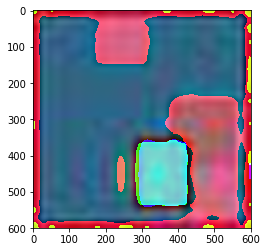

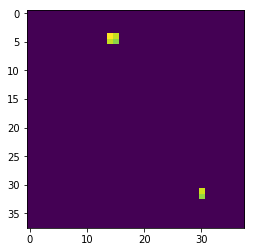

In [8]:
plt.imshow(X[0][7])
plt.show()
plt.imshow(Y[1][0][7].sum(axis=-1))
plt.show()

In [25]:
from keras.layers import TimeDistributed

(1, 38, 38, 18)

In [3]:
d = get_data('./videos/', './annotations/')

Parsing annotation files


In [4]:
d[0][0]

[{'bboxes': [{'class': 'bbox', 'x1': 12, 'x2': 14, 'y1': 10, 'y2': 14},
   {'class': 'bbox', 'x1': 24, 'x2': 26, 'y1': 0, 'y2': 4}],
  'filename': './videos/8/0.jpg',
  'height': 32,
  'width': 32},
 {'bboxes': [{'class': 'bbox', 'x1': 11, 'x2': 13, 'y1': 8, 'y2': 12},
   {'class': 'bbox', 'x1': 24, 'x2': 26, 'y1': 2, 'y2': 6}],
  'filename': './videos/8/1.jpg',
  'height': 32,
  'width': 32},
 {'bboxes': [{'class': 'bbox', 'x1': 10, 'x2': 12, 'y1': 6, 'y2': 10},
   {'class': 'bbox', 'x1': 24, 'x2': 26, 'y1': 4, 'y2': 8}],
  'filename': './videos/8/2.jpg',
  'height': 32,
  'width': 32},
 {'bboxes': [{'class': 'bbox', 'x1': 9, 'x2': 11, 'y1': 4, 'y2': 8},
   {'class': 'bbox', 'x1': 24, 'x2': 26, 'y1': 6, 'y2': 10}],
  'filename': './videos/8/3.jpg',
  'height': 32,
  'width': 32},
 {'bboxes': [{'class': 'bbox', 'x1': 8, 'x2': 10, 'y1': 2, 'y2': 6},
   {'class': 'bbox', 'x1': 24, 'x2': 26, 'y1': 7, 'y2': 11}],
  'filename': './videos/8/4.jpg',
  'height': 32,
  'width': 32},
 {'bboxes':

In [11]:
len(d[0])

20